# **Roadmap:**
### - [Setup](#Environment-setup-for-Kubeless-functions-and-Q-learning)
### - [Training algorithm](#Train-the-agent)
### - [Result plots](#Analyze-results)

# Environment setup for Kubeless functions and Q learning

## Install the gym-k8s package that registers our environments

In [ ]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas seaborn

In [ ]:
import gym
import pickle
import random
import subprocess
import time
import numpy as np
from threading import Lock, Thread

## Info of the Kubeless app we want to deploy

In [ ]:
# Timestep duration in minutes
# We wait these many minutes for our actions to be enforced
timestep_duration = 6
app_name = 'fibonacci'
input_file = '~/serverless-elasticity-management/examples/kubeless/fibonacci-python/app.py'
handler_fun = 'app.fibonacci'
memory_req = '128Mi'
cpu_req = '80m'
sla_latency = 0.25
prometheus_host = 'http://localhost:9090/'
# Nginx ingress latency metric
prometheus_latency_metric_name = '(sum(rate(nginx_ingress_controller_request_duration_seconds_sum'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'\
    '/(sum(rate(nginx_ingress_controller_request_duration_seconds_count'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'.format(app_name, timestep_duration)
gym_env = 'gym_k8s:k8s-env-discrete-state-discrete-action-v6'
q_table_file = 'DynaQ+kubeless-env-discrete-state-discrete-action-V6-data.npy'
tau_table_file = 'DynaQ+kubeless-env-discrete-state-discrete-action-V6-tau.npy'
model_file = 'model.pickle'
q_table_init_value = 50
total_epochs = 60
num_of_services = 15
steps_per_epoch = 16
planning_steps = 150

## Load or create the Q table
If our Q table file is present, we load in into memory. Otherwise we create a gym environment and using the environment's observation and space dimensions, we create a new one.

In [ ]:
try:
    q_table = np.load(q_table_file)

    print('File present. Loading done!')
except IOError:
    env = gym.make(
        gym_env,
        timestep_duration=timestep_duration,
        app_name=app_name,
        sla_latency=sla_latency,
        prometheus_host=prometheus_host,
        prometheus_latency_metric_name=prometheus_latency_metric_name
    )

    q_table = np.full((env.observation_space.n, env.action_space.n), q_table_init_value)
    np.save(q_table_file, q_table)

    print('File not present. Created successfully!')

## Load or create the Tau table
This table tracks how many timesteps has been since the transition has been tried.

If our tau table file is present, we load in into memory. Otherwise we create a gym environment and using the environment's observation and space dimensions, we create a new one.

In [ ]:
try:
    tau_table = np.load(tau_table_file)

    print('File present. Loading done!')
except IOError:
    env = gym.make(
        gym_env,
        timestep_duration=timestep_duration,
        app_name=app_name,
        sla_latency=sla_latency,
        prometheus_host=prometheus_host,
        prometheus_latency_metric_name=prometheus_latency_metric_name
    )

    tau_table = np.zeros((env.observation_space.n, env.action_space.n))
    np.save(tau_table_file, tau_table)

    print('File not present. Created successfully!')

# Load or create the model dictionary

In [ ]:
try:
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    print('File present. Loading done!')
except IOError:
    model = {}

    print('File not present. Created model successfully!')

In [ ]:
lock = Lock()

## Create historical states csv file if it doesn't exist

In [ ]:
try:
    open('k8s_historical_states_discrete.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('k8s_historical_states_discrete.csv', 'w') as f:
        f.write('current_app_name,timestep,state,action,next_state,reward,'
                'done,number_of_pods,cpu_util,latency_violation,latency,hpa_threshold,info\n')
    print('File not present. Created successfully!')

# Train the agent

Federated Learning
--------------------------

- Deploy multiple copies of our application (ex. 60) each on its own thread


- Separate execution in batches of 1 epoch = timestep_duration * 60 * 8 seconds  
  (We stress the applications with a varying load)


- Every action needs timestep_duration minutes to get enforced and we have 8 samples every epoch for each service


- For each epoch we have 8 * timestep_duration timesteps  

## Function creation
These functions deploy a new Kubeless function in k8s and create an ingress object with a different hostname for each:

In [ ]:
def deploy_service(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    deploy_args = {
        'service_name': current_app_name,
        'input_file': input_file,
        'handler_fun': handler_fun,
        'memory_req': memory_req,
        'cpu_req': cpu_req
    }

    msg = subprocess.getoutput('kubeless function deploy {service_name} --runtime python3.7 '
                               '--from-file {input_file} '
                               '--handler {handler_fun} '
                               '--label service-name={service_name} '
                               '--memory {memory_req} '
                               '--cpu {cpu_req}'.format(**deploy_args))
    print(msg)

In [ ]:
def create_ingress(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    ingress_create_args = {
        'service_name': current_app_name,
        'hostname': 'kubeless-{}-python.default.127.0.0.1.nip.io'.format(current_app_name)
    }

    msg = subprocess.getoutput('kubeless trigger http create {service_name} '
                               '--function-name {service_name} '
                               '--hostname {hostname}'.format(**ingress_create_args))
    print(msg)

## Stress functions

We use a vegeta script to stress our application:

In [ ]:
def stress_function(endpoint):
    rate_per_second = 0.5
    rate_per_minute = int(rate_per_second * 60)

    vegeta_process = subprocess.Popen('stress-test/vegeta-stress.sh {} {} {}'
                   .format(endpoint, rate_per_minute, timestep_duration * 2), shell=True)
    return vegeta_process

## Function cleanup
This function deletes our Kubeless functions. The ingress objects and the HPAs are also deleted:

In [ ]:
def delete_service(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    msg = subprocess.getoutput('kubeless function delete {}'.format(current_app_name))
    print(msg)

## Agent training
This function trains our agent:

In [ ]:
def train_agent(num_service):
    global q_table
    global tau_table
    global model

    # Hyperparameters
    alpha = 0.1
    gamma = 0.9
    kappa = 0.001
    epsilon_init = 0.97
    epsilon_min = 0.2

    current_app_name = '{}{}'.format(app_name, num_service)
    endpoint = 'kubeless-{}-python.default.127.0.0.1.nip.io:8000'.format(current_app_name)
    current_latency_metric_name = prometheus_latency_metric_name.replace(app_name, current_app_name)
    
    env = gym.make(
        gym_env,
        timestep_duration=timestep_duration,
        app_name=current_app_name,
        sla_latency=sla_latency,
        prometheus_host=prometheus_host,
        prometheus_latency_metric_name=current_latency_metric_name
    )

    for epoch in range(0, total_epochs):
        state, _ = env.reset()
        done = False

        vegeta_process = stress_function(endpoint)

        for step in range(steps_per_epoch):
            print('===Epoch:{}-Round:{}-App:{}==='
                  .format(epoch, step, current_app_name))

            current_timestep = epoch * steps_per_epoch + step
            
            # Epsilon keeps getting smaller and stops when it reaches epsilon_min
            current_epsilon = pow(epsilon_init, current_timestep)
            epsilon = max(current_epsilon, epsilon_min)
            
            if done:
                vegeta_process.kill()
                delete_service(num_service)
                time.sleep(2 * 60)

                deploy_service(num_service)
                time.sleep(60)
                create_ingress(num_service)
                
                break
            else:
                if random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()  # Explore action space, non-greedy (NG) action selection
                else:
                    action = np.argmax(q_table[state])  # Exploit learned values, greedy (G) action selection
                
                next_state, real_ob, reward, done, info = env.step(action)

                (pod_cpu_util,
                 cpu_threshold,
                 number_of_pods,
                 latency) = real_ob

                # Latency violation becomes 1 if the SLA was violated
                # otherwise it's 0
                latency_violation = int(latency > sla_latency)

                # Save historical tuple
                with open('k8s_historical_states_discrete.csv', 'a') as f:
                    f.write(
                        '{},{},{},{},'.format(current_app_name, current_timestep, state, action) +
                        '{},{},{},{},'.format(next_state, reward, done, number_of_pods) +
                        '{},{},{},{},{}'.format(pod_cpu_util, latency_violation, latency, cpu_threshold, info) +
                        '\n'
                    )

                with lock:
                    # Increase all transitions by one timestep and set our current transition to 0
                    tau_table += 1
                    tau_table[state][action] = 0

                    old_value = q_table[state, action]
                    # Q-table update is always greedy (np.max)
                    # Q-learning is off-policy since the action taken can be of a different policy (non-greedy, random) (NG)
                    next_max = np.max(q_table[next_state])
                    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                    q_table[state, action] = new_value

                    # DynaQ+
                    # Update model
                    if state not in model:
                        model[state] = {action: (next_state, reward)}

                        # The first time we add a transition to the model,
                        # we also set transitions for all other actions that
                        # return to the same state and give a reward of 0
                        for rem_action in range(env.action_space.n):
                            if rem_action != action:
                                model[state][rem_action] = state, 50
                    else:
                        model[state][action] = next_state, reward

                    # Simulate experience
                    for _ in range(planning_steps):
                        past_state = np.random.choice(list(model.keys()))
                        past_action = np.random.choice(list(model[past_state].keys()))
                        (simulated_next_state,
                         simulated_reward) = model[past_state][past_action]
                        simulated_reward += kappa * np.sqrt(tau_table[past_state][past_action])

                        # Update Q-table
                        old_value = q_table[past_state, past_action]
                        next_max = np.max(q_table[simulated_next_state])
                        new_value = (1 - alpha) * old_value + \
                            alpha * (simulated_reward + gamma * next_max)

                        q_table[past_state, past_action] = new_value

                state = next_state

        with lock:
            np.save(q_table_file, q_table)
            np.save(tau_table_file, tau_table)
            with open(model_file, 'wb') as f: 
                pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

        print('Training finished.\n')

## Deploy services in k8s

In [ ]:
for x in range(num_of_services):
    deploy_service(x)

Wait long enough for the functions to be visible before we create the ingress objects.

In [ ]:
time.sleep(60)

In [ ]:
for x in range(num_of_services):
    create_ingress(x)

## Create one thread per environment and execute them

In [ ]:
threads = [Thread(target=train_agent, args=(x,)) for x in range(num_of_services)]

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

## Cleanup
Delete services:

In [ ]:
for x in range(num_of_services):
    delete_service(x)

# Analyze results

- [Resources diagram per epoch](#Resources-diagram-per-epoch)
- [Resources diagram per timestep](#Resources-diagram-per-timestep)
- [Resources diagram per stress phase](#Resources-diagram-per-stress-phase)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('whitegrid')

data = pd.read_csv('old-outputs/08DynaQ/k8s_historical_states_discrete.csv')

Convert timesteps to epochs:

In [2]:
data_copy = data.copy()
grouped_data = data_copy.groupby(['timestep'], as_index=False)

steps_per_epoch = 16
data['timestep'] = data['timestep'].floordiv(steps_per_epoch)
epoch_grouped_data = data.groupby(['timestep'], as_index=False)

Average results over all services:

In [3]:
data_mean = grouped_data.mean()
data_sum = grouped_data.sum()

epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()

## States visited

In [4]:
'''q_table_file = 'DynaQ+kubeless-env-discrete-state-discrete-action-V6-data.npy'
q_table_init_value = 50

tab = np.load(q_table_file)

initial_state_values = [q_table_init_value for x in range(3)]

states = []
for state, array in enumerate(tab):
    if not np.array_equal(array, initial_state_values):
        states.append(state)

print('States visited', len(states), '/',
    len(tab), 'or', round(100 * len(states) / len(tab)), '%\n')
print('States:', states)'''

"q_table_file = 'DynaQ+kubeless-env-discrete-state-discrete-action-V6-data.npy'\nq_table_init_value = 50\n\ntab = np.load(q_table_file)\n\ninitial_state_values = [q_table_init_value for x in range(3)]\n\nstates = []\nfor state, array in enumerate(tab):\n    if not np.array_equal(array, initial_state_values):\n        states.append(state)\n\nprint('States visited', len(states), '/',\n    len(tab), 'or', round(100 * len(states) / len(tab)), '%\n')\nprint('States:', states)"

## Resources diagram per epoch

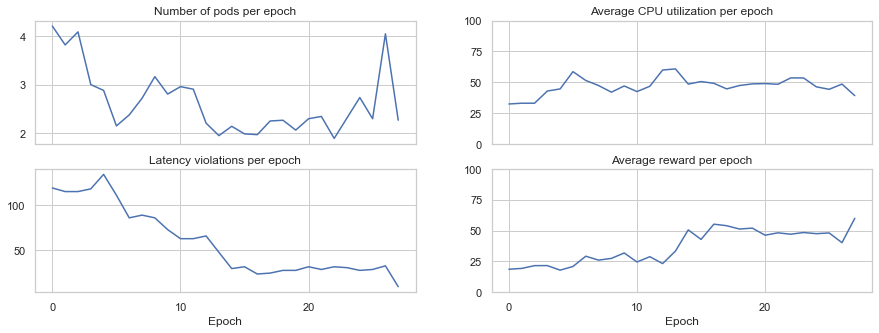

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

ax = axs[0, 0]
epoch_data_mean.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, title='Number of pods per epoch')

ax = axs[0, 1]
ax.set_ylim(0, 100)
epoch_data_mean.plot(kind='line', x='timestep', y='cpu_util', ax=ax, title='Average CPU utilization per epoch')

ax = axs[1, 0]
epoch_data_sum.plot(kind='line', x='timestep', y='latency_violation', ax=ax, title='Latency violations per epoch')

ax = axs[1, 1]
ax.set_ylim(0, 100)
epoch_data_mean.plot(kind='line', x='timestep', y='reward', ax=ax, title='Average reward per epoch')

for ax_array in axs:
    for ax in ax_array:
        ax.set_xlabel('Epoch')
        ax.legend().set_visible(False)
        ax.locator_params(tight=True, nbins=4)

plt.show()

## Resources diagram per timestep

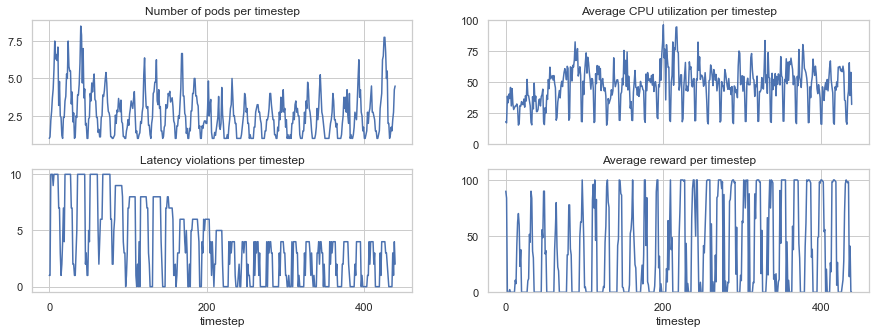

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

ax = axs[0, 0]
data_mean.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, title='Number of pods per timestep')

ax = axs[0, 1]
ax.set_ylim(0, 100)
data_mean.plot(kind='line', x='timestep', y='cpu_util', ax=ax, title='Average CPU utilization per timestep')

ax = axs[1, 0]
data_sum.plot(kind='line', x='timestep', y='latency_violation', ax=ax, title='Latency violations per timestep')

ax = axs[1, 1]
ax.set_ylim(0, 110)
data_mean.plot(kind='line', x='timestep', y='reward', ax=ax, title='Average reward per timestep')

for ax_array in axs:
    for ax in ax_array:
        ax.legend().set_visible(False)
        ax.locator_params(tight=True, nbins=4)

plt.show()

## Resources diagram per stress phase

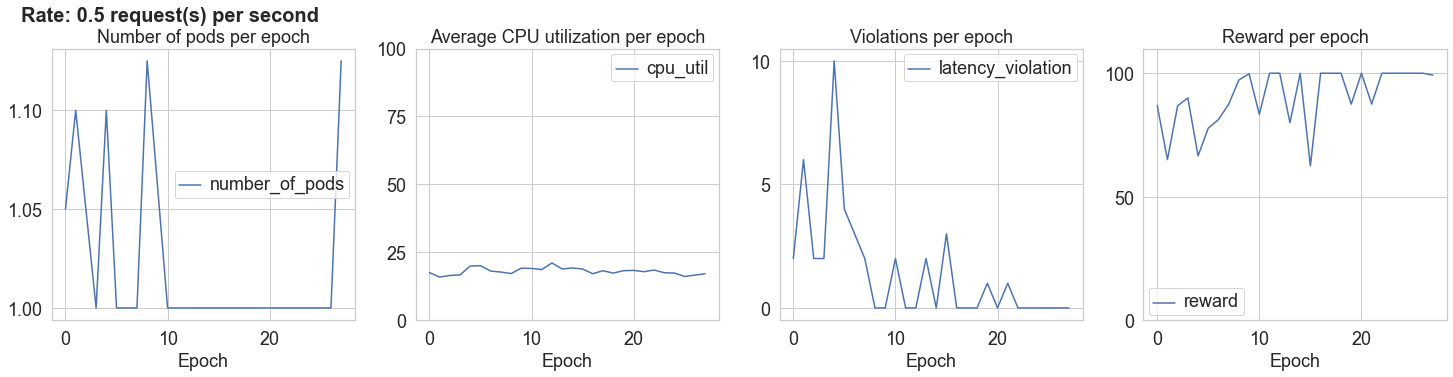

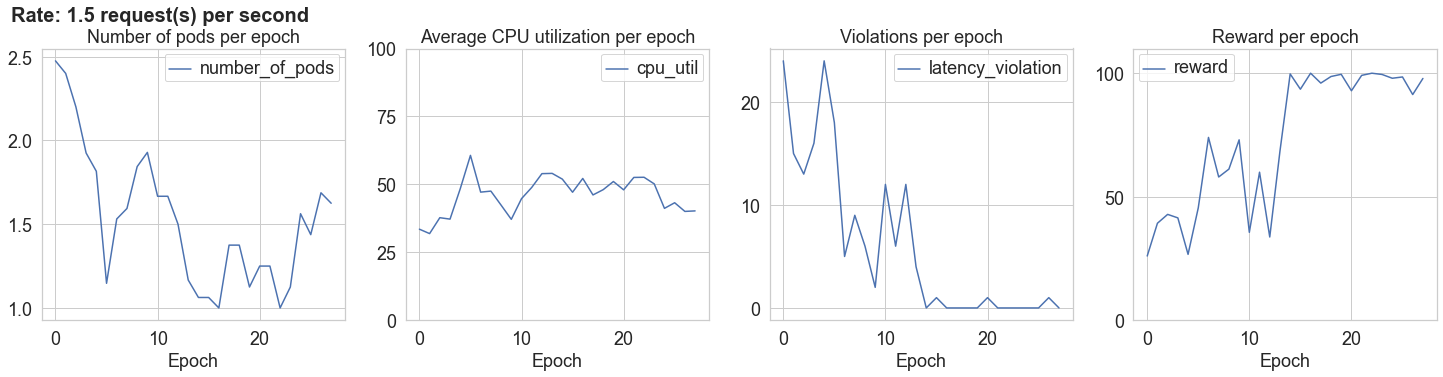

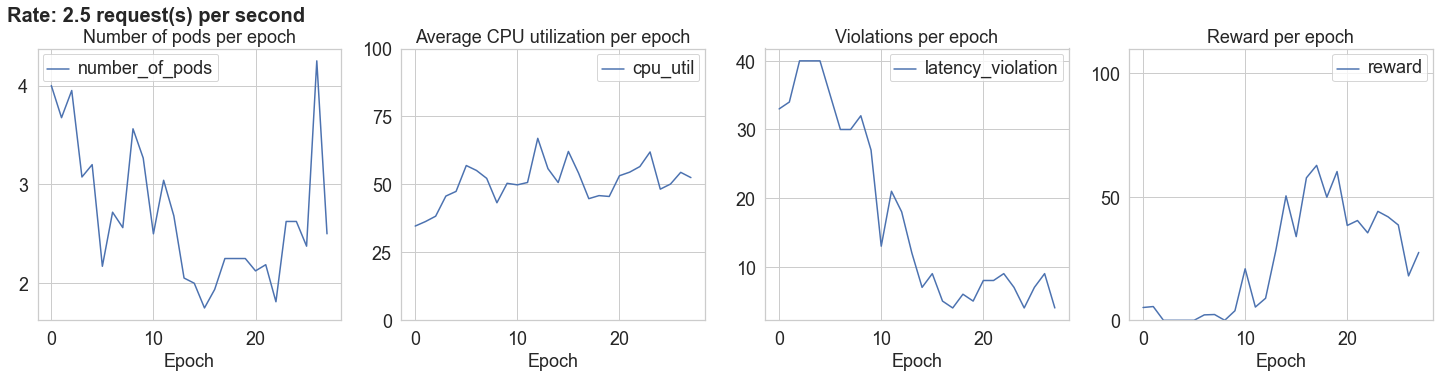

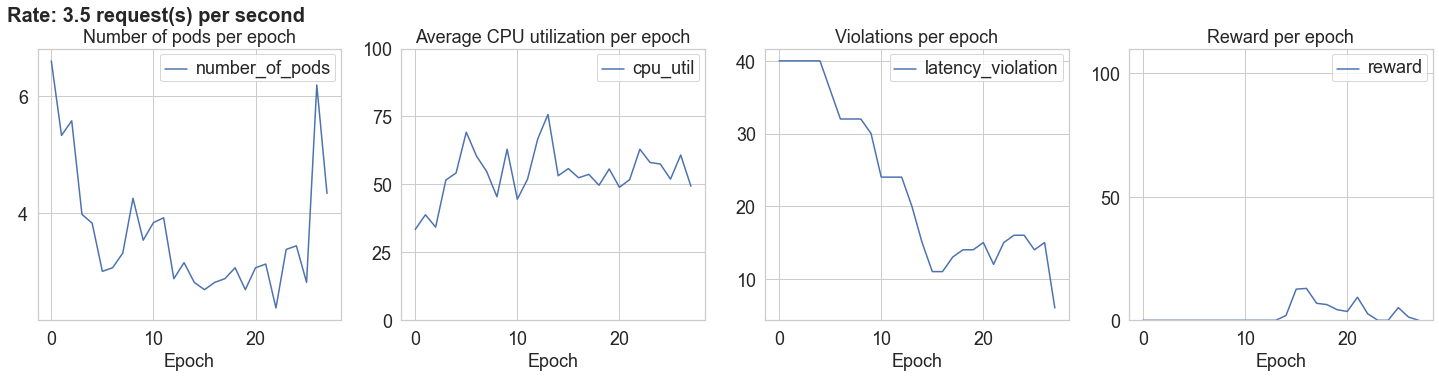

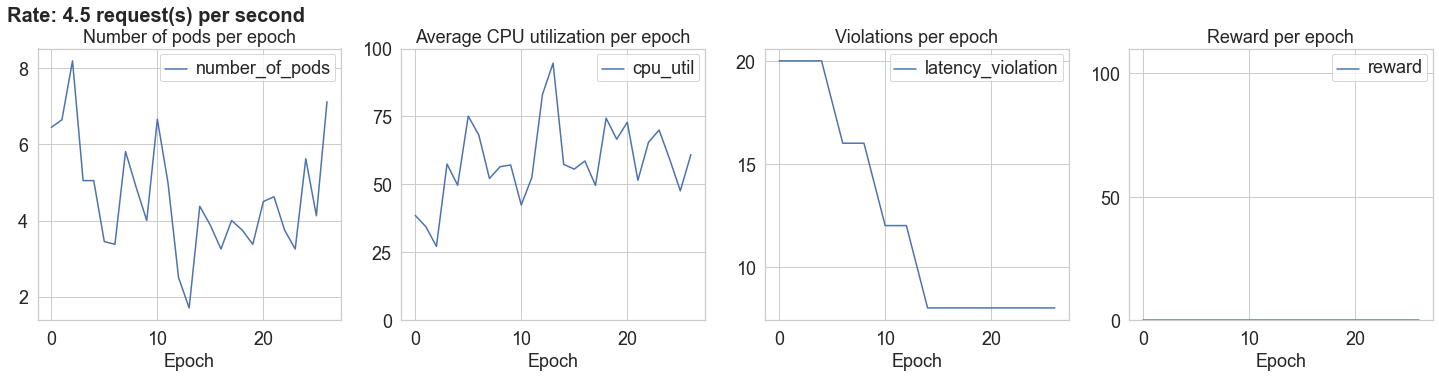

In [7]:
steps_per_epoch = 16
rate_per_second = 0.5

rates_timesteps_dict = {
    rate_per_second: [0, 1],
    3 * rate_per_second: [2, 3, 14, 15],
    5 * rate_per_second: [4, 5, 12, 13],
    7 * rate_per_second: [6, 7, 10, 11],
    9 * rate_per_second: [8, 9]
}

for rate in rates_timesteps_dict:
    local_copy = data_copy[data_copy.timestep.mod(steps_per_epoch).isin(rates_timesteps_dict[rate])].copy()
    local_copy['timestep'] = local_copy['timestep'].floordiv(steps_per_epoch)
    local_copy_grouped = local_copy.groupby(['timestep'], as_index=False)
    local_copy_mean = local_copy_grouped.mean()
    local_copy_sum = local_copy_grouped.sum()

    fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharex=True)

    ax = axs[0]
    local_copy_mean.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, title='Number of pods per epoch', legend=None)
    annotation = 'Rate: {} request(s) per second'.format(rate)
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, 
            size=20, weight='bold')

    ax = axs[1]
    ax.set_ylim(0, 100)
    local_copy_mean.plot(kind='line', x='timestep', y='cpu_util', ax=ax, title='Average CPU utilization per epoch', legend=None)

    ax = axs[2]
    local_copy_sum.plot(kind='line', x='timestep', y='latency_violation', ax=ax, title='Violations per epoch')
    ax.legend(['Latency violations'])

    ax = axs[3]
    ax.set_ylim(0, 110)
    local_copy_mean.plot(kind='line', x='timestep', y='reward', ax=ax, title='Reward per epoch', legend=None)
    
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.locator_params(tight=True, nbins=4)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()) + ax.legend().get_texts():
            item.set_fontsize(18)

    plt.show()